In [1]:
from imutils import build_montages
import numpy as np
import pandas as pd
import io
from PIL import Image  
from matplotlib import pyplot as plt                                                                                                                             
import glob
import os
import cv2
import imageio
import copy
from sklearn.model_selection import train_test_split

### MAKE PAIRS

In [2]:
def make_pairs(images):
    pairImages = []
    pairLabels = []
    
    arr = [] 
    arrAux = []

    # array of arrays with classes ([[0,1,2,3,4], [5, 6, 7, 8, 9], ...])
    for i in range(0, 10001):
        if ((i % 5 == 0) & (i != 0)):
            arr.append(arrAux)
            arrAux = []
            arrAux.append(i)
        else:
            arrAux.append(i)
    
    # do pairs
    for i in range(len(images)):
        currentImage = images[i]
        label = i//5   # class of currentImage (changes from 5 to 5)
        
        # positive pairs
        posIdx = np.random.choice(arr[label])
        posImage = images[posIdx]
        pairImages.append([currentImage, posImage])
        pairLabels.append([1])
        
        # negative pairs
        arrNeg = arr[:label] + arr[label+1:]
        arrNeg = np.array(arrNeg)
        arrNeg = arrNeg.flatten()
        negIdx = np.random.choice(arrNeg)
        negImage = images[negIdx]
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])
        
    return [np.array(pairImages), np.array(pairLabels)]

In [3]:
os.chdir(r'') #insert the path of the folder with the dataset images (after DataProcessing)
filelist = glob.glob('*.jpeg')
filelist = sorted(filelist)
# normalize the data
images = np.array([np.array(Image.open(fname)) /255 for fname in filelist])

In [33]:
images[0].shape

(299, 299)

In [4]:
# add Dimension
images3Dim = []
for img in images:
    img3D = img.reshape(299, 299, 1)
    images3Dim.append(img3D)

In [34]:
images3Dim[0].shape

(299, 299, 1)

In [5]:
dataset = make_pairs(images3Dim)

In [6]:
pairs = dataset[0]
labels = dataset[1]
print('Img A')
print(pairs[0][0])   # imgA
print('Img B')
print(pairs[0][1])   # imgB
print('Label')
print(labels[0])     # label of the first pair (pos or neg)

Img A
[[[0.76470588]
  [0.76470588]
  [0.76862745]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.76470588]
  [0.76470588]
  [0.76862745]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.76470588]
  [0.76470588]
  [0.76862745]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 ...

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]]
Img B
[[[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 ...

 [[0.76470588]
  [0.76470588]
  [0.76470588]
  ...
  [0.        ]
  [0.        ]
  [0.        

In [31]:
pairs.shape #[[imgA, imgB], ...]

(20000, 2, 299, 299, 1)

In [32]:
labels.shape #[[0], [1], ...]

(20000, 1)

### SPLIT

In [7]:
trainPairs, testPairs, trainLabels, testLabels = train_test_split(pairs, labels, test_size=0.3, random_state=123)
print(trainPairs.shape)
print(testPairs.shape)
print(trainLabels.shape)
print(testLabels.shape)

(14000, 2, 299, 299, 1)
(6000, 2, 299, 299, 1)
(14000, 1)
(6000, 1)


### NETWORK

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras import backend as K
from matplotlib import cm
import tensorflow as tf
import heapq

In [26]:
# specify the shape of the inputs for our network
IMG_SHAPE = (299, 299, 1)
# specify the batch size and number of epochs
BATCH_SIZE = 128
EPOCHS = 10

In [24]:
def build_siamese_model(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)
    # build the model
    model = Model(inputs, outputs)
    return model

In [27]:
net = build_siamese_model(IMG_SHAPE)
net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 299, 299, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 149, 149, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 149, 149, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 128)       147584

In [29]:
def euclidean_distance(vectors):
    (featsA, featsB) = vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,keepdims=True)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [30]:
imgA = Input(shape= IMG_SHAPE)
imgB = Input(shape= IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 299, 299, 1) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 299, 299, 1) 0                                            
__________________________________________________________________________________________________
model_2 (Functional)            (None, 48)           523440      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model_2[0][0]              

In [37]:
# compile the model
model.compile(loss="binary_crossentropy", optimizer= "adam", metrics=["accuracy"])

In [ ]:
imgsA = copy.deepcopy(trainPairs[ : , 0]) # only the 1º image of each pair

In [ ]:
imgsB = copy.deepcopy(trainPairs[ : , 1]) # only the 2º image of each pair

In [ ]:
# callbacks
early = EarlyStopping(monitor='val_loss', patience=3)
path = 'siamese.h5'
checkpoint = ModelCheckpoint(filepath= path, monitor= 'val_loss', save_best_only= True)

In [ ]:
# train the model
history = model.fit([imgsA, imgsB], trainLabels[:], validation_split=0.1, 
                    batch_size= BATCH_SIZE, epochs= EPOCHS, callbacks=[early, checkpoint], verbose = 1)

### RESULTS

In [38]:
model = load_model('') #insert name of the .h5 file

In [ ]:
# creates the training plot to show the evolution of some parameters
def plot_training(H, plotPath):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Plot")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

In [ ]:
plot_training(history, 'trainPlot.png')

In [41]:
testA = testPairs[:, 0]
testB = testPairs[:, 1]

In [42]:
# evaluate model
score = model.evaluate([testA, testB], testLabels, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

188/188 [==============================] - 981s 5s/step - loss: 0.2427 - accuracy: 0.9768
Test loss: 0.2427113652229309
Test accuracy: 0.9768333435058594


In [11]:
# select 10 specific pairs to test (change to see diferent results)
chosenA = testPairs[10:20, 0]
chosenB = testPairs[10:20, 1]

In [12]:
# print the similarity values between each pair
preds = model.predict([chosenA, chosenB])
print(preds)

array([[0.11144832],
       [0.02689999],
       [0.00631246],
       [0.00145602],
       [0.00263387],
       [0.2991311 ],
       [0.69497025],
       [0.35477743],
       [0.6373647 ],
       [0.6566684 ]], dtype=float32)

In [13]:
# convert from array to image
def toImage(arr):
    arrAux = arr.reshape(299, 299)
    arrAux = arrAux * 255
    return Image.fromarray(arrAux)

In [14]:
def showSimilarity(i, preds, imgA, imgB):
    proba = preds[i][0]
    
    fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
    plt.suptitle("Similarity: {:.2f}".format(proba))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    imA = toImage(imgA)
    plt.imshow(imA, cmap=plt.cm.gray)
    plt.axis("off")
    # show second image
    ax = fig.add_subplot(1, 2, 2)
    imB = toImage(imgB)
    plt.imshow(imB, cmap=plt.cm.gray)
    plt.axis("off")
    # show the plot
    plt.show()

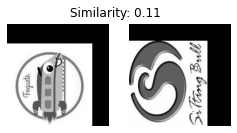

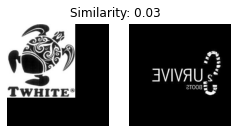

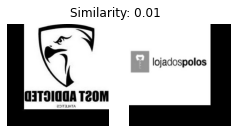

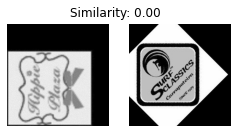

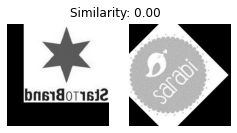

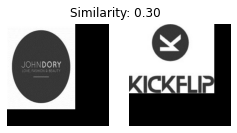

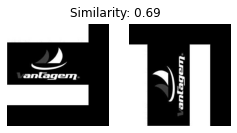

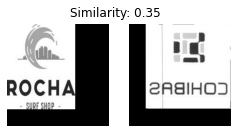

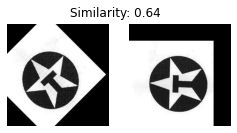

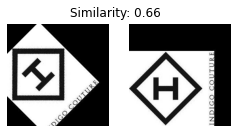

In [15]:
for i in range(0,10):
    showSimilarity(i, preds, chosenA[i], chosenB[i])

### TOP 5

In [20]:
# choose file to check the top 5 similar images
# warning: image must be 299x299 and grayscaled
os.chdir(r'') #insert the path of the folder with the dataset images (after DataProcessing)
file = glob.glob('') #insert the name of the chosen image from the folder

In [21]:
file[0]

'468928.jpeg'

In [22]:
def top5(file):
    # open file and pre processing the correspondent image
    image = np.array(Image.open(file))
    image = image / 255
    image = image.reshape(299, 299, 1)
    # form pairs with the chosen image 
    totalPairs = []
    for img in images3Dim:
        totalPairs.append([image, img])
    totalPairs = np.array(totalPairs)
    imgsA = totalPairs[:, 0] # only the 1º image of each pair
    imgsB = totalPairs[:, 1] # only the 2º image of each pair
    preds = model.predict([imgsA, imgsB])
    # select the 5 indexes with the greatest similarity
    arrTop5 = heapq.nlargest(5, range(len(preds)), preds.__getitem__)
    # show the top 5 images
    for i in arrTop5:
        [a, b] = totalPairs[i]
        showSimilarity(i, preds, a, b)

[4065, 4067, 4066, 4060, 4380]


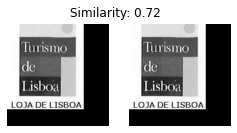

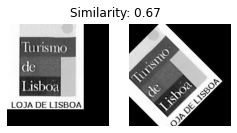

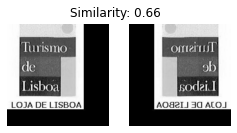

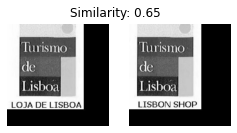

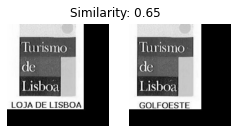

In [23]:
top5(file[0])